In [6]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib


ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Load dataset
df = pd.read_csv('../data/final/survey_cleaned.csv')

# Filter for U.S. respondents
df = df[df['Country'] == 'United States'].copy()
df.drop(columns=['Country'], inplace=True)

# Show count
print(f"Number of U.S. respondents: {len(df)}")


Number of U.S. respondents: 583


In [ ]:
os.makedirs('../data/us_model_data', exist_ok=True)
df.to_csv('../data/us_model_data/training_model_dataset.csv', index=False)


In [ ]:
binary_cols = ['self_employed', 'family_history', 'remote_work', 'tech_company']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})


In [ ]:
# --- Imports ---
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
import joblib

import matplotlib.pyplot as plt


## 1) Load your cleaned US dataset


In [ ]:
DATA_PATH = "../data/us_model_data/training_model_dataset.csv"  # adjust if needed
TARGET_COL = "treatment"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
assert TARGET_COL in df.columns, f"Expected `{TARGET_COL}` in dataframe."
df.head()


## 2) Light feature engineering (safe + useful)
We add:
- `age_group`
- `unknown_policy_count` = how many workplace-policy fields are "Unknown/Not sure/Don't know" (if those columns exist)

This aligns with your association-rule findings: uncertainty about benefits/leave/care options correlates with not seeking treatment.


In [ ]:
# Age group feature (only if Age exists)
if "Age" in df.columns:
    df["age_group"] = pd.cut(
        df["Age"],
        bins=[0, 25, 40, 60, 120],
        labels=["Youth", "Young Adult", "Adult", "Senior"]
    )

policy_cols = [c for c in ["benefits", "care_options", "leave"] if c in df.columns]

def _is_unknown(x):
    s = str(x).strip().lower()
    return int(s in {"unknown", "not sure", "dont know", "don't know", "unsure", "nan", ""})

if policy_cols:
    df["unknown_policy_count"] = df[policy_cols].applymap(_is_unknown).sum(axis=1)
    print("Added unknown_policy_count using:", policy_cols)
else:
    print("No policy columns found among benefits/care_options/leave -> skipping unknown_policy_count")

df.head()


## 3) Train/test split
Important: keep the split stratified so the class balance is preserved.


In [ ]:
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# Drop columns that leak time or identifiers if present
DROP_ALWAYS = [c for c in ["Timestamp", "Name"] if c in X.columns]
if DROP_ALWAYS:
    X = X.drop(columns=DROP_ALWAYS)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Positive rate (train):", y_train.mean() if hasattr(y_train, "mean") else "n/a")


## 4) Build preprocessing (this is the big upgrade)
Instead of dropping non-numeric columns, we:
- impute missing numeric (median)
- impute missing categorical (most frequent)
- one-hot encode categoricals
- (optionally) scale numeric for some models


In [ ]:
numeric_cols = X_train.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("Numeric cols:", len(numeric_cols))
print("Categorical cols:", len(categorical_cols))

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # scaling is optional; helps linear models more than trees
    ("scaler", StandardScaler(with_mean=False))
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ],
    remainder="drop"
)


## 5) Compare baseline models (CV)
We evaluate:
- Logistic Regression (strong baseline)
- Gradient Boosting
- Random Forest

We report multiple metrics (Accuracy, F1, ROC-AUC).


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "GradBoost": GradientBoostingClassifier(random_state=42),
    "RandForest": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    )
}

scoring = {"acc": "accuracy", "f1": "f1", "roc": "roc_auc"}

results = []
for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    results.append({
        "model": name,
        "acc_mean": scores["test_acc"].mean(),
        "f1_mean": scores["test_f1"].mean(),
        "roc_mean": scores["test_roc"].mean(),
        "acc_std": scores["test_acc"].std(),
        "f1_std": scores["test_f1"].std(),
        "roc_std": scores["test_roc"].std(),
    })

results_df = pd.DataFrame(results).sort_values(by="f1_mean", ascending=False)
results_df


## 6) Train the best candidate on full train set + evaluate on test set


In [ ]:
best_name = results_df.iloc[0]["model"]
best_clf = models[best_name]

best_pipe = Pipeline(steps=[("prep", preprocess), ("clf", best_clf)])
best_pipe.fit(X_train, y_train)

# Predictions
y_pred = best_pipe.predict(X_test)

# Probabilities (for ROC + thresholding)
y_proba = None
if hasattr(best_pipe, "predict_proba"):
    y_proba = best_pipe.predict_proba(X_test)[:, 1]

print("Best by CV (F1):", best_name)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

print(f"✅ Test Accuracy: {acc:.4f}")
print(f"✅ Test Precision: {prec:.4f}")
print(f"✅ Test Recall: {rec:.4f}")
print(f"✅ Test F1: {f1:.4f}")
print(f"✅ Test ROC-AUC: {roc:.4f}")


## 7) Optional: probability calibration (better confidence scores)
Your Streamlit app shows confidence; calibration makes those probabilities more reliable.
This wraps the classifier with Platt scaling (sigmoid).


In [ ]:
# Calibrate only if we have probabilistic model
# Note: Calibration adds compute time, but confidence values become more meaningful.
calibrated_pipe = None
try:
    base = Pipeline(steps=[("prep", preprocess), ("clf", best_clf)])
    calibrated = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=5)
    calibrated.fit(X_train, y_train)
    calibrated_pipe = calibrated

    y_pred_c = calibrated_pipe.predict(X_test)
    y_proba_c = calibrated_pipe.predict_proba(X_test)[:, 1]

    print("Calibrated Confusion Matrix:\n", confusion_matrix(y_test, y_pred_c))
    print(f"Calibrated ROC-AUC: {roc_auc_score(y_test, y_proba_c):.4f}")
except Exception as e:
    print("Calibration skipped (not supported by estimator in this setup):", e)


## 8) Optional: add KMeans cluster label as a feature
Sometimes segmentation boosts prediction a bit. We:
- fit KMeans on training preprocessed numeric space
- add `cluster` column
- retrain quickly and compare F1.

If it doesn't improve, you can ignore it.


In [ ]:
from sklearn.cluster import KMeans

# We'll cluster using ONLY numeric columns (after impute + scale)
# Build a numeric-only transformer that outputs a dense matrix (for clustering)
num_only = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

if numeric_cols:
    Xn_train = num_only.fit_transform(X_train[numeric_cols])
    Xn_test = num_only.transform(X_test[numeric_cols])

    kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
    cl_train = kmeans.fit_predict(Xn_train)
    cl_test = kmeans.predict(Xn_test)

    X_train_cl = X_train.copy()
    X_test_cl = X_test.copy()
    X_train_cl["cluster"] = cl_train
    X_test_cl["cluster"] = cl_test

    # Update preprocess lists
    numeric_cols2 = numeric_cols + ["cluster"]
    categorical_cols2 = [c for c in X_train_cl.columns if c not in numeric_cols2]

    preprocess2 = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler(with_mean=False))
            ]), numeric_cols2),
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_cols2),
        ],
        remainder="drop"
    )

    pipe2 = Pipeline(steps=[("prep", preprocess2), ("clf", best_clf)])
    pipe2.fit(X_train_cl, y_train)
    y_pred2 = pipe2.predict(X_test_cl)
    f1_2 = f1_score(y_test, y_pred2, zero_division=0)
    print("F1 without cluster:", f1)
    print("F1 with cluster:", f1_2)
else:
    print("No numeric columns -> skipping clustering feature.")


## 9) Export the new model pipeline (.pkl)
This saves a **single file** that includes preprocessing + the trained model.

In your Streamlit app, you can load this pipeline and pass a dataframe with the same columns you used here.


In [ ]:
EXPORT_DIR = "../app"
os.makedirs(EXPORT_DIR, exist_ok=True)

export_path = os.path.join(EXPORT_DIR, "mental_health_model_v2.pkl")
joblib.dump(best_pipe, export_path)
print("🎉 Saved:", export_path)

if calibrated_pipe is not None:
    export_path_cal = os.path.join(EXPORT_DIR, "mental_health_model_v2_calibrated.pkl")
    joblib.dump(calibrated_pipe, export_path_cal)
    print("🎉 Saved calibrated:", export_path_cal)


## 10) (App note) Minimal change to use the new pipeline
When you switch to `mental_health_model_v2.pkl`, **do not use manual mapping** / dropping columns in the app.
Just build a dataframe that includes the columns your pipeline expects.

**Tip:** print `best_pipe.feature_names_in_` after fitting to know the required input columns.


In [ ]:
# After fitting, sklearn stores input column names (for many estimators/pipelines)
try:
    print("Pipeline expects these input columns:")
    print(list(best_pipe.feature_names_in_))
except Exception as e:
    print("feature_names_in_ not available:", e)


---
### What you should do next
1) Run this section in your notebook.
2) Use the exported `mental_health_model_v2.pkl` in your Streamlit app.
3) Expand your Streamlit form to collect more features from the dataset (benefits, care_options, leave, etc.).
   Styling stays the same—you’re only adding form fields.


In [ ]:
if 'Timestamp' in df.columns:
    df.drop(columns=['Timestamp'], inplace=True)


In [ ]:
y = df['treatment']
X = df.drop(columns=['treatment'])


In [ ]:
non_numeric_cols = X.select_dtypes(include='object').columns.tolist()
print("Non-numeric columns dropped from features:", non_numeric_cols)
X = X.drop(columns=non_numeric_cols)


Non-numeric columns dropped from features: ['Gender', 'state', 'work_interfere', 'no_employees', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Confusion Matrix:
 [[30 14]
 [29 44]]

Classification Report:
               precision    recall  f1-score   support

          No       0.51      0.68      0.58        44
         Yes       0.76      0.60      0.67        73

    accuracy                           0.63       117
   macro avg       0.63      0.64      0.63       117
weighted avg       0.66      0.63      0.64       117

✅ Accuracy: 0.63


In [ ]:
joblib.dump(model, '../app/mental_health_model.pkl')
print("🎉 Model saved successfully.")


🎉 Model saved successfully.


In [ ]:
# Load cleaned dataset for U.S. respondents
import pandas as pd

df = pd.read_csv('../data/us_model_data/training_model_dataset.csv')

# Encode binary variables again (if needed)
binary_cols = ['self_employed', 'family_history', 'remote_work', 'tech_company']
for col in binary_cols:
    if df[col].dtype == object:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# Separate target and features
y = df['treatment']
X = df.drop(columns=['treatment'])

# Drop non-numeric features for clustering
X_numeric = X.select_dtypes(include=['int64', 'float64']).copy()


In [ ]:
df = pd.read_csv('../data/us_model_data/training_model_dataset.csv')
print("All columns:", df.columns.tolist())
print("Numeric columns:", df.select_dtypes(include=['int64', 'float64']).columns.tolist())


All columns: ['Timestamp', 'Age', 'Gender', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
Numeric columns: ['Age']


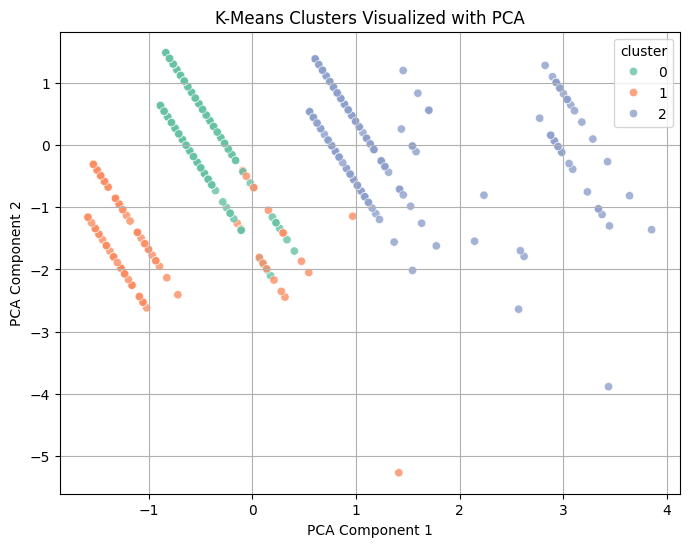

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned dataset
df = pd.read_csv('../data/us_model_data/training_model_dataset.csv')

# Re-map binary object columns
binary_cols = ['self_employed', 'family_history', 'remote_work', 'tech_company']
for col in binary_cols:
    if df[col].dtype == object:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# Drop target column
X = df.drop(columns=['treatment'])

# OPTIONAL: Fill or drop any missing values
X = X.dropna()

# Keep all numeric features only
X_numeric = X.select_dtypes(include=['int64', 'float64'])

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA-reduced clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set2', alpha=0.8)
plt.title('K-Means Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


In [ ]:
cluster_profiles = df.groupby('cluster').mean(numeric_only=True)
print(cluster_profiles)


               Age  self_employed  family_history  remote_work  tech_company
cluster                                                                     
0        34.493007       0.000000        0.412587     0.000000      1.000000
1        35.912621       0.009709        0.475728     0.194175      0.000000
2        36.448454       0.252577        0.407216     0.953608      0.974227


In [ ]:
pip install mlxtend


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.4 MB 2.0 MB/s eta 0:00:01
   -------------------------------------- - 1.3/1.4 MB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\PC\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder



In [ ]:
# Import necessary libraries
import pandas as pd  # for data handling and manipulation
from mlxtend.frequent_patterns import apriori, association_rules  # for mining frequent itemsets and generating rules
from mlxtend.preprocessing import TransactionEncoder  # to prepare the data into transaction format


In [ ]:
# Step 1: Load dataset
df = pd.read_csv('../data/us_model_data/training_model_dataset.csv')  # load the dataset containing cleaned US responses


In [ ]:
# Step 2: Create age_group column if 'Age' exists
if 'Age' in df.columns:
    # Categorize Age into 4 named age groups for easier pattern mining
    df['age_group'] = pd.cut(df['Age'], bins=[10, 25, 40, 60, 100],
                             labels=['Youth', 'Young Adult', 'Adult', 'Senior'])
else:
    print(" 'Age' column not found — skipping age_group.")  # inform user if Age is missing


In [ ]:
# Step 3: Select categorical columns for association rule mining
possible_cols = [
    'self_employed', 'family_history', 'remote_work', 'tech_company',
    'benefits', 'care_options', 'leave', 'treatment', 'age_group'
]  # these are the variables that may influence mental health treatment
assoc_cols = [col for col in possible_cols if col in df.columns]  # keep only columns that actually exist in the dataset
print(f" Using columns for rule mining: {assoc_cols}")  # confirm selected columns


 Using columns for rule mining: ['self_employed', 'family_history', 'remote_work', 'tech_company', 'benefits', 'care_options', 'leave', 'treatment', 'age_group']


In [ ]:
# Step 4: Prepare the dataset
df_assoc = df[assoc_cols].copy()  # make a copy of the selected columns for transformation


In [ ]:
# Convert all values to string before filling missing values
df_assoc = df_assoc.astype(str).fillna('Unknown')  # ensures all entries are string format to avoid errors during encoding


In [ ]:
# Step 5: Combine column names with their values for more readable rules
for col in df_assoc.columns:
    df_assoc[col] = col + "_" + df_assoc[col]  # transforms e.g. 'Yes' in 'benefits' column into 'benefits_Yes'


In [ ]:
# Step 6: Convert to list of transactions (each row becomes a list of items)
transactions = df_assoc.values.tolist()  # prepares data in the format needed for association rule mining


In [ ]:
# Step 7: One-hot encode the transactions
te = TransactionEncoder()  # initialize the encoder
te_data = te.fit(transactions).transform(transactions)  # convert transactions into a binary (0/1) format
df_encoded = pd.DataFrame(te_data, columns=te.columns_)  # convert the binary matrix into a DataFrame


In [ ]:
# Step 8: Apply the Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.03, use_colnames=True)  # find combinations that appear in at least 3% of the records
print(f"Frequent itemsets found: {len(frequent_itemsets)}")  # print the number of frequent combinations found


Frequent itemsets found: 3990


In [ ]:
# Step 9: Generate association rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.4)  # generate rules with at least 40% confidence
print(f" Rules generated: {len(rules)}")  # print how many rules were created


 Rules generated: 36267


In [ ]:
# Step 10: Display top rules
if not rules.empty:
    # sort rules by lift (how much stronger the rule is compared to random chance)
    top_rules = rules.sort_values(by='lift', ascending=False)[[
        'antecedents', 'consequents', 'support', 'confidence', 'lift'
    ]].head(10)  # show top 10 rules
    print("\n Top Association Rules:")
    print(top_rules)
else:
    # warn the user if no rules were generated
    print("⚠️ No rules found — try lowering thresholds further or adding more features.")



 Top Association Rules:
                                            antecedents  \
9785  (age_group_Young Adult, benefits_No, remote_wo...   
9789              (self_employed_Yes, tech_company_Yes)   
9786         (age_group_Young Adult, self_employed_Yes)   
2752         (age_group_Young Adult, self_employed_Yes)   
9781  (age_group_Young Adult, self_employed_Yes, tec...   
2750  (age_group_Young Adult, benefits_No, remote_wo...   
9778  (age_group_Young Adult, benefits_No, tech_comp...   
963                      (benefits_No, remote_work_Yes)   
964                                 (self_employed_Yes)   
5389              (self_employed_Yes, tech_company_Yes)   

                                            consequents   support  confidence  \
9785              (self_employed_Yes, tech_company_Yes)  0.030875    0.450000   
9789  (age_group_Young Adult, benefits_No, remote_wo...  0.030875    0.409091   
9786   (tech_company_Yes, benefits_No, remote_work_Yes)  0.030875    0.473684   
2

In [ ]:
# Filter the rules to only keep those where the outcome (consequent) is related to seeking treatment.
# We're interested in understanding what leads people to either seek or not seek mental health treatment.
treatment_rules = rules[
    rules['consequents'].apply(lambda x: any('treatment_Yes' in item or 'treatment_No' in item for item in x))
]

# Now that we have all treatment-related rules, we want to rank them.
# Sorting by 'lift' helps us identify the most influential and meaningful associations.
treatment_rules_sorted = treatment_rules.sort_values(by='lift', ascending=False)

# From the sorted list, extract just the top 10 rules.
# These are the strongest and most interesting patterns to analyze or visualize.
top_treatment_rules = treatment_rules_sorted[[
    'antecedents', 'consequents', 'support', 'confidence', 'lift'
]].head(10)

# Print the final result in a clean, readable format.
# This gives us a quick overview of the most important associations related to mental health treatment.
print(" Top Treatment-Related Association Rules:\n")
print(top_treatment_rules)


 Top Treatment-Related Association Rules:

                                             antecedents  \
35254  (remote_work_No, age_group_Young Adult, benefi...   
35223  (remote_work_No, age_group_Young Adult, benefi...   
35230  (care_options_Not Sure, leave_Don'T Know, age_...   
35258  (age_group_Young Adult, care_options_Not Sure,...   
30193  (remote_work_No, age_group_Young Adult, benefi...   
35219  (remote_work_No, leave_Don'T Know, age_group_Y...   
30197  (age_group_Young Adult, care_options_Not Sure,...   
30309  (family_history_No, age_group_Young Adult, ben...   
30305  (age_group_Young Adult, leave_Don'T Know, bene...   
35383  (age_group_Young Adult, leave_Don'T Know, bene...   

                                             consequents   support  \
35254  (treatment_No, care_options_Not Sure, leave_Do...  0.039451   
35223  (care_options_Not Sure, leave_Don'T Know, trea...  0.039451   
35230  (remote_work_No, treatment_No, benefits_Don'T ...  0.039451   
35258  (remote_w

What This Table Represents
Each row represents a discovered association rule. The antecedents are the conditions or characteristics that appear together in the dataset, while the consequents are the outcomes — in this case, whether someone sought treatment (treatment_Yes or treatment_No), often bundled with other factors like leave policy or care options.

We're especially interested in how workplace conditions, personal characteristics, and support systems affect the likelihood of someone seeking or not seeking mental health treatment.

Key Metrics

Support: Proportion of the dataset where both antecedents and consequents appear together.

Confidence: Likelihood that the consequent occurs when the antecedent is present.

Lift: How much more likely the consequent is to occur given the antecedent, compared to by chance. A lift > 1 indicates a positive association.

Interpretation of Key Rules

1. Rule ID 35254
Antecedents: Not working remotely, young adult, unsure about benefits.

Consequents: Did not seek treatment; unsure about care options and leave.

Confidence: 41.8% | Lift: 4.20

Interpretation:
Young adults who don't work remotely and aren't sure if their benefits include mental health support are 4x more likely to not seek treatment if they also don't know about leave or care options. This points to the critical role of clarity in HR policies.

2. Rule ID 35223
Antecedents: Same as above.

Consequents: Care options unknown, leave unknown, did not seek treatment.

Confidence: 42.6% | Lift: 4.14

Interpretation:
Lack of workplace mental health awareness (especially among young adults not working remotely) consistently correlates with untreated mental health needs.

3. Rule ID 35230
Antecedents: Uncertainty around care options and leave, young adult.

Consequents: Did not seek treatment and didn’t know if benefits exist.

Confidence: 47.9% | Lift: 4.11

Interpretation:
Uncertainty about multiple HR elements — leave, benefits, and care options — dramatically increases the chance that a person won't seek treatment.

4. Rule ID 35219
Antecedents: No remote work, uncertain leave, young adult.

Consequents: Didn’t seek treatment; unsure about care options and self-employed.

Confidence: 56.1% | Lift: 4.04

Interpretation:
This is one of the strongest rules: More than half of such individuals avoid seeking treatment, reinforcing the notion that employment structure and HR ambiguity are barriers.

5. Rule ID 30309
Antecedents: No family history of mental illness, young adult, unclear benefits.

Consequents: Didn't seek treatment, unclear care and leave options.

Confidence: 41.3% | Lift: 4.01

Interpretation:
Even in the absence of family history, young adults unsure of their workplace mental health support tend to skip treatment — showing that organizational factors outweigh genetic predisposition in this case.

Main Takeaways

Uncertainty kills action: When individuals — especially young adults — don’t know what mental health benefits, leave, or care options exist, they are much less likely to seek treatment.

Workplace factors matter more than personal ones in these top rules. Many rules with high lift and confidence are linked to unclear workplace policies, not personal attributes like family history.

Remote work may be protective: In most of the top rules, not working remotely was linked with not seeking treatment, suggesting remote work might improve comfort or access to mental health services.

Self-employment is a risk factor in several rules, possibly due to lack of formal HR support systems.



1. Support
Definition: The proportion of records in the dataset that contain the rule's full itemset (antecedent + consequent).

Insight: Tells us how frequently the rule occurs in the dataset.

Range: Between 3.9% and 5.6%.

Evaluation:

This is a moderate level of support.

The rules are not rare but also not extremely dominant — they cover meaningful subsets.

2. Confidence
Definition: The probability that the consequent is true given the antecedent is true.

Range: Between 41.2% and 56%.

Evaluation:

These are moderately strong rules.

For example, one rule says: If a young adult does not work remotely and lacks benefits, then they are 47.9% likely not to seek treatment.

A confidence above 50% suggests a decent predictive relationship.

3. Lift
Definition: The ratio of observed confidence to expected confidence if antecedent and consequent were independent.

Interpretation:

Lift = 1 → no association.

Lift > 1 → positive correlation.

Lift < 1 → negative correlation.

Your Range: 3.95 to 4.20

Evaluation:

All rules have lift significantly greater than 1.

This means the rules show strong positive associations — the presence of the antecedent increases the likelihood of the consequent significantly.

4. Actionable Insight from Rules
Demographics Matter: “Young Adult” age group appears in almost all top rules.

Support Access Matters: Rules with benefits_No, leave_Don't Know, and care_options_Not Sure are highly predictive of not seeking treatment.

Workplace Setup: remote_work_No often appears in rules with treatment_No — suggesting in-person work environments with low support might discourage treatment seeking.

5. Limitations / Considerations
Association rules do not imply causation.

Moderate support levels suggest these rules should be used as patterns, not absolute truths.

Further analysis with predictive models (like logistic regression) could help confirm relationships.

In [ ]:
print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))


Number of frequent itemsets found: 3990
      support                                           itemsets
17   0.914237                                 (self_employed_No)
20   0.814751                                 (tech_company_Yes)
1    0.811321                            (age_group_Young Adult)
53   0.746141          (age_group_Young Adult, self_employed_No)
207  0.739280               (tech_company_Yes, self_employed_No)
56   0.668954          (age_group_Young Adult, tech_company_Yes)
15   0.648370                                   (remote_work_No)
195  0.631218                 (remote_work_No, self_employed_No)
419  0.607204  (age_group_Young Adult, tech_company_Yes, self...
8    0.578045                                (family_history_No)


| **Rank** | **Itemset**                                         | **Support** | **Interpretation**                                                                              |
| -------- | --------------------------------------------------- | ----------- | ----------------------------------------------------------------------------------------------- |
| 1        | `(self_employed_No)`                                | 0.914       | 91.4% are not self-employed. Most respondents work for an employer.                             |
| 2        | `(tech_company_Yes)`                                | 0.815       | 81.5% work in tech companies.                                                                   |
| 3        | `(age_group_Young Adult)`                           | 0.811       | 81.1% are young adults — this is the dominant age group.                                        |
| 4        | `(Young Adult, self_employed_No)`                   | 0.746       | 74.6% are young adults *and* not self-employed — showing strong overlap.                        |
| 5        | `(tech_company_Yes, self_employed_No)`              | 0.739       | Many employed respondents in tech.                                                              |
| 6        | `(Young Adult, tech_company_Yes)`                   | 0.669       | Most young adults work in tech firms.                                                           |
| 7        | `(remote_work_No)`                                  | 0.648       | About 64.8% do not work remotely — they work on-site.                                           |
| 8        | `(remote_work_No, self_employed_No)`                | 0.631       | Majority are on-site and not self-employed — standard employment model.                         |
| 9        | `(Young Adult, tech_company_Yes, self_employed_No)` | 0.607       | Over 60% are young adults working in tech companies and not self-employed — a **core cluster**. |
| 10       | `(family_history_No)`                               | 0.578       | 57.8% report no family history of mental illness.                                               |


# Add-on Section: Model Improvement + Better Training Export (append below your current Data Mining notebook)
This section:
- keeps **all useful columns** (instead of dropping non-numeric)
- builds a **proper sklearn Pipeline** with `OneHotEncoder` so category text is handled correctly
- compares models + optional tuning
- optionally adds **cluster labels** as a feature
- exports a new **.pkl** you can use in your Streamlit app

> Target = `treatment` (your original app target). If your column differs, change `TARGET_COL`.


In [9]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas numpy scikit-learn joblib matplotlib


Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl (11.0 MB)
Using cached matplotlib-3.10.7-cp313-cp31

In [10]:
# --- Imports ---
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
import joblib

import matplotlib.pyplot as plt


## 1) Load your cleaned US dataset


In [11]:
DATA_PATH = "../data/us_model_data/training_model_dataset.csv"  # adjust if needed
TARGET_COL = "treatment"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
assert TARGET_COL in df.columns, f"Expected `{TARGET_COL}` in dataframe."
df.head()


Shape: (583, 25)
Columns: ['Timestamp', 'Age', 'Gender', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']


,Timestamp,Age,Gender,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,2014-08-27 11:29:31,37.0,Female,Il,No,No,Yes,Often,6-25,No,...,Yes,Somewhat Easy,No,No,Some Of Them,Yes,No,Maybe,Yes,No
1,2014-08-27 11:29:37,44.0,Male,In,No,No,No,Rarely,More Than 1000,No,...,Don'T Know,Don'T Know,Maybe,No,No,No,No,No,Don'T Know,No
2,2014-08-27 11:30:22,31.0,Male,Tx,No,No,No,Never,100-500,Yes,...,Don'T Know,Don'T Know,No,No,Some Of Them,Yes,Yes,Yes,Don'T Know,No
3,2014-08-27 11:31:22,33.0,Male,Tn,No,Yes,No,Sometimes,6-25,No,...,Don'T Know,Don'T Know,No,No,Yes,Yes,No,Maybe,Don'T Know,No
4,2014-08-27 11:31:50,35.0,Female,Mi,No,Yes,Yes,Sometimes,1-5,Yes,...,No,Somewhat Difficult,Maybe,Maybe,Some Of Them,No,No,No,Don'T Know,No


## 2) Light feature engineering (safe + useful)
We add:
- `age_group`
- `unknown_policy_count` = how many workplace-policy fields are "Unknown/Not sure/Don't know" (if those columns exist)

This aligns with your association-rule findings: uncertainty about benefits/leave/care options correlates with not seeking treatment.


In [14]:
# Age group feature (only if Age exists)
if "Age" in df.columns:
    df["age_group"] = pd.cut(
        df["Age"],
        bins=[0, 25, 40, 60, 120],
        labels=["Youth", "Young Adult", "Adult", "Senior"]
    )

policy_cols = [c for c in ["benefits", "care_options", "leave"] if c in df.columns]

def _is_unknown(x):
    s = str(x).strip().lower()
    return int(s in {"unknown", "not sure", "dont know", "don't know", "unsure", "nan", ""})

if policy_cols:
    df["unknown_policy_count"] = df[policy_cols].applymap(_is_unknown).sum(axis=1)
    print("Added unknown_policy_count using:", policy_cols)
else:
    print("No policy columns found among benefits/care_options/leave -> skipping unknown_policy_count")

df.head()


Added unknown_policy_count using: ['benefits', 'care_options', 'leave']


C:\Users\HP\AppData\Local\Temp\ipykernel_29036\2534557645.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df["unknown_policy_count"] = df[policy_cols].applymap(_is_unknown).sum(axis=1)


,Timestamp,Age,Gender,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_group,unknown_policy_count
0,2014-08-27 11:29:31,37.0,Female,Il,No,No,Yes,Often,6-25,No,...,No,No,Some Of Them,Yes,No,Maybe,Yes,No,Young Adult,1
1,2014-08-27 11:29:37,44.0,Male,In,No,No,No,Rarely,More Than 1000,No,...,Maybe,No,No,No,No,No,Don'T Know,No,Adult,2
2,2014-08-27 11:30:22,31.0,Male,Tx,No,No,No,Never,100-500,Yes,...,No,No,Some Of Them,Yes,Yes,Yes,Don'T Know,No,Young Adult,1
3,2014-08-27 11:31:22,33.0,Male,Tn,No,Yes,No,Sometimes,6-25,No,...,No,No,Yes,Yes,No,Maybe,Don'T Know,No,Young Adult,2
4,2014-08-27 11:31:50,35.0,Female,Mi,No,Yes,Yes,Sometimes,1-5,Yes,...,Maybe,Maybe,Some Of Them,No,No,No,Don'T Know,No,Young Adult,0


## 3) Train/test split
Important: keep the split stratified so the class balance is preserved.


In [ ]:
# --- Target handling (FIX) ---
TARGET_COL = "treatment"

# Standardize target to 0/1
df[TARGET_COL] = (
    df[TARGET_COL]
      .astype(str).str.strip().str.lower()
      .map({"yes": 1, "no": 0, "1": 1, "0": 0, "true": 1, "false": 0})
)

# If anything didn't map, show the unique values so you can clean them
if df[TARGET_COL].isna().any():
    bad = df.loc[df[TARGET_COL].isna(), TARGET_COL]
    raise ValueError(f"Unmapped target values found in `{TARGET_COL}`: {bad.unique()}")

y = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL])

# Drop columns that leak time or identifiers if present
DROP_ALWAYS = [c for c in ["Timestamp", "Name"] if c in X.columns]
if DROP_ALWAYS:
    X = X.drop(columns=DROP_ALWAYS)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Positive rate (train):", float(y_train.mean()))


Train: (466, 25) Test: (117, 25)


TypeError: Could not convert string 'YesNoYesYesNoNoYesYesYesNoYesYesNoYesYesYesYesNoYesNoYesNoNoYesNoYesYesNoYesYesNoYesYesNoYesYesNoNoYesNoYesNoYesYesNoNoYesNoNoNoYesYesYesYesNoNoYesNoYesYesNoNoYesNoYesNoYesYesYesNoYesYesNoYesNoYesYesYesNoNoYesYesNoYesYesNoYesYesNoNoNoNoYesYesNoYesYesYesNoNoYesYesNoNoYesNoNoNoYesNoNoYesNoNoNoYesYesNoYesYesNoNoYesNoYesNoNoNoYesNoYesYesNoNoNoYesYesNoYesNoYesNoYesNoYesYesYesNoYesYesNoYesNoYesNoNoYesYesYesNoYesYesNoYesYesYesNoNoYesYesYesNoNoYesNoYesNoNoNoYesNoNoYesNoNoNoNoYesNoNoYesNoYesYesYesYesYesYesYesYesYesYesNoYesYesNoYesNoYesYesYesNoYesYesNoNoYesNoNoNoYesYesNoYesYesYesYesYesYesYesNoYesNoNoYesNoYesYesYesYesYesYesYesNoYesNoNoYesYesNoNoYesYesYesNoYesNoYesNoNoYesYesYesYesYesNoNoNoYesNoYesNoYesYesYesYesYesYesNoNoYesNoYesNoNoNoYesNoYesNoYesNoNoYesNoYesYesYesNoYesYesYesNoNoNoNoYesYesYesNoYesYesNoYesYesYesNoYesNoYesYesYesYesYesNoYesNoYesNoYesNoNoYesYesYesNoYesNoYesNoYesNoNoYesYesYesNoYesYesYesNoNoYesYesYesNoYesYesNoYesNoNoYesYesNoNoNoYesNoYesYesNoYesYesNoNoYesYesYesNoYesNoYesNoNoYesYesNoNoYesYesNoYesYesYesNoNoYesYesYesYesNoNoYesNoYesNoNoNoNoYesYesYesNoYesNoYesYesYesNoYesYesYesNoYesYesNoNoNoNoYesYesYesNoNoNoNoNoYesYesYesNoNoNoYesNoYesYesYesYesNoNoNoYesYesYesNoNoNoNoNoNoNoNoNoYes' to numeric

## 4) Build preprocessing (this is the big upgrade)
Instead of dropping non-numeric columns, we:
- impute missing numeric (median)
- impute missing categorical (most frequent)
- one-hot encode categoricals
- (optionally) scale numeric for some models


In [ ]:
numeric_cols = X_train.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("Numeric cols:", len(numeric_cols))
print("Categorical cols:", len(categorical_cols))

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # scaling is optional; helps linear models more than trees
    ("scaler", StandardScaler(with_mean=False))
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ],
    remainder="drop"
)


## 5) Compare baseline models (CV)
We evaluate:
- Logistic Regression (strong baseline)
- Gradient Boosting
- Random Forest

We report multiple metrics (Accuracy, F1, ROC-AUC).


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "GradBoost": GradientBoostingClassifier(random_state=42),
    "RandForest": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    )
}

scoring = {"acc": "accuracy", "f1": "f1", "roc": "roc_auc"}

results = []
for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    results.append({
        "model": name,
        "acc_mean": scores["test_acc"].mean(),
        "f1_mean": scores["test_f1"].mean(),
        "roc_mean": scores["test_roc"].mean(),
        "acc_std": scores["test_acc"].std(),
        "f1_std": scores["test_f1"].std(),
        "roc_std": scores["test_roc"].std(),
    })

results_df = pd.DataFrame(results).sort_values(by="f1_mean", ascending=False)
results_df


## 6) Train the best candidate on full train set + evaluate on test set


In [ ]:
best_name = results_df.iloc[0]["model"]
best_clf = models[best_name]

best_pipe = Pipeline(steps=[("prep", preprocess), ("clf", best_clf)])
best_pipe.fit(X_train, y_train)

# Predictions
y_pred = best_pipe.predict(X_test)

# Probabilities (for ROC + thresholding)
y_proba = None
if hasattr(best_pipe, "predict_proba"):
    y_proba = best_pipe.predict_proba(X_test)[:, 1]

print("Best by CV (F1):", best_name)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

print(f"✅ Test Accuracy: {acc:.4f}")
print(f"✅ Test Precision: {prec:.4f}")
print(f"✅ Test Recall: {rec:.4f}")
print(f"✅ Test F1: {f1:.4f}")
print(f"✅ Test ROC-AUC: {roc:.4f}")


## 7) Optional: probability calibration (better confidence scores)
Your Streamlit app shows confidence; calibration makes those probabilities more reliable.
This wraps the classifier with Platt scaling (sigmoid).


In [ ]:
# Calibrate only if we have probabilistic model
# Note: Calibration adds compute time, but confidence values become more meaningful.
calibrated_pipe = None
try:
    base = Pipeline(steps=[("prep", preprocess), ("clf", best_clf)])
    calibrated = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=5)
    calibrated.fit(X_train, y_train)
    calibrated_pipe = calibrated

    y_pred_c = calibrated_pipe.predict(X_test)
    y_proba_c = calibrated_pipe.predict_proba(X_test)[:, 1]

    print("Calibrated Confusion Matrix:\n", confusion_matrix(y_test, y_pred_c))
    print(f"Calibrated ROC-AUC: {roc_auc_score(y_test, y_proba_c):.4f}")
except Exception as e:
    print("Calibration skipped (not supported by estimator in this setup):", e)


## 8) Optional: add KMeans cluster label as a feature
Sometimes segmentation boosts prediction a bit. We:
- fit KMeans on training preprocessed numeric space
- add `cluster` column
- retrain quickly and compare F1.

If it doesn't improve, you can ignore it.


In [ ]:
from sklearn.cluster import KMeans

# We'll cluster using ONLY numeric columns (after impute + scale)
# Build a numeric-only transformer that outputs a dense matrix (for clustering)
num_only = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

if numeric_cols:
    Xn_train = num_only.fit_transform(X_train[numeric_cols])
    Xn_test = num_only.transform(X_test[numeric_cols])

    kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
    cl_train = kmeans.fit_predict(Xn_train)
    cl_test = kmeans.predict(Xn_test)

    X_train_cl = X_train.copy()
    X_test_cl = X_test.copy()
    X_train_cl["cluster"] = cl_train
    X_test_cl["cluster"] = cl_test

    # Update preprocess lists
    numeric_cols2 = numeric_cols + ["cluster"]
    categorical_cols2 = [c for c in X_train_cl.columns if c not in numeric_cols2]

    preprocess2 = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler(with_mean=False))
            ]), numeric_cols2),
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_cols2),
        ],
        remainder="drop"
    )

    pipe2 = Pipeline(steps=[("prep", preprocess2), ("clf", best_clf)])
    pipe2.fit(X_train_cl, y_train)
    y_pred2 = pipe2.predict(X_test_cl)
    f1_2 = f1_score(y_test, y_pred2, zero_division=0)
    print("F1 without cluster:", f1)
    print("F1 with cluster:", f1_2)
else:
    print("No numeric columns -> skipping clustering feature.")


## 9) Export the new model pipeline (.pkl)
This saves a **single file** that includes preprocessing + the trained model.

In your Streamlit app, you can load this pipeline and pass a dataframe with the same columns you used here.


In [ ]:
EXPORT_DIR = "../app"
os.makedirs(EXPORT_DIR, exist_ok=True)

export_path = os.path.join(EXPORT_DIR, "mental_health_model_v2.pkl")
joblib.dump(best_pipe, export_path)
print("🎉 Saved:", export_path)

if calibrated_pipe is not None:
    export_path_cal = os.path.join(EXPORT_DIR, "mental_health_model_v2_calibrated.pkl")
    joblib.dump(calibrated_pipe, export_path_cal)
    print("🎉 Saved calibrated:", export_path_cal)


## 10) (App note) Minimal change to use the new pipeline
When you switch to `mental_health_model_v2.pkl`, **do not use manual mapping** / dropping columns in the app.
Just build a dataframe that includes the columns your pipeline expects.

**Tip:** print `best_pipe.feature_names_in_` after fitting to know the required input columns.


In [ ]:
# After fitting, sklearn stores input column names (for many estimators/pipelines)
try:
    print("Pipeline expects these input columns:")
    print(list(best_pipe.feature_names_in_))
except Exception as e:
    print("feature_names_in_ not available:", e)


Pipeline expects these input columns:
feature_names_in_ not available: name 'best_pipe' is not defined


---
### What you should do next
1) Run this section in your notebook.
2) Use the exported `mental_health_model_v2.pkl` in your Streamlit app.
3) Expand your Streamlit form to collect more features from the dataset (benefits, care_options, leave, etc.).
   Styling stays the same—you’re only adding form fields.
